In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats.sampling import NumericalInversePolynomial
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

In [2]:
class ConstantDensity:
  rmax = 1000
  def __init__(self, rmax=1000):
    self.rmax = rmax
  def pdf(self, x):
    if(isinstance(x, (list, tuple, np.ndarray))):
      return np.array(list(map(self.pdf, x)))
    if(x<0 or x>self.rmax): return 0
    return 3/self.rmax**3*x*x

class ExponentiallyDecreasing:
  rlen = 1000
  def __init__(self, rlen=1000):
    self.rlen = rlen
  def pdf(self, x):
    if(isinstance(x, (list, tuple, np.ndarray))):
      return np.array(list(map(self.pdf, x)))
    a = x/self.rlen
    if(x<=0): return 0
    return 1/(2*self.rlen)*a**2*np.exp(-a)

In [3]:
cek = np.arange(5)
dist3 = ExponentiallyDecreasing(100)
dist3.pdf(cek)

# isinstance(cek, (list, tuple, np.ndarray))

array([0.00000000e+00, 4.95024917e-07, 1.96039735e-06, 4.36700490e-06,
       7.68631551e-06])

/tmp/ipykernel_32711/2758564764.py:20: RuntimeWarning: invalid value encountered in double_scalars
  return 1/(2*self.rlen)*a**2*np.exp(-a)


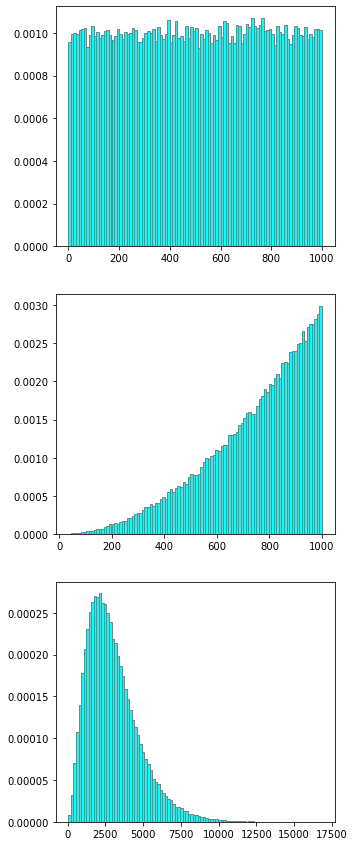

In [4]:
N = 1e5
rmax = 1E3

# Uniform random sampling
r1 = uniform.rvs(size=int(N), scale=rmax)

# Constant Density random sampling
dist2 = ConstantDensity(rmax)
rng2 = NumericalInversePolynomial(dist2)
r2 = rng2.rvs(size=int(1E5))

# Exponentially Decreasing random sampling
rlen = 1E3
dist3 = ExponentiallyDecreasing(rlen)
rng3 = NumericalInversePolynomial(dist3)
r3 = rng3.rvs(size=int(1E5))

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,15))
ax1.hist(r1, bins=100, density=True, histtype='bar', edgecolor = "gray", color="aqua")
ax2.hist(r2, bins=100, density=True, histtype='bar', edgecolor = "gray", color="aqua")
ax3.hist(r3, bins=100, density=True, histtype='bar', edgecolor = "gray", color="aqua")
plt.show()

In [5]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

job = Gaia.launch_job_async(""" 
SELECT TOP 100 *
FROM gaiadr2.gaia_source
WHERE parallax > 0
""")
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [54]:
r["parallax"][0]

0.6368483093390329

In [55]:
1000/r["parallax"][0]

1570.2326367763653

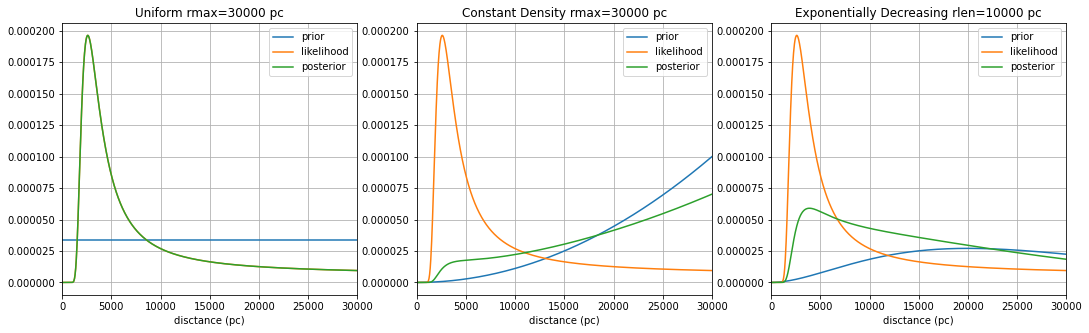

parallax (mas) 0.38333928615043145
parallax_error (mas) 0.1420982263940761
f 0.37068526897165816


In [6]:
# Data
parallax = r["parallax"][99]/1000
parallax_error = r["parallax_error"][0]/1000

# Preliminary
rmax = 3E4
distance = np.linspace(1, rmax, 1000)
likelihood = norm.pdf(x=1/distance, scale=parallax_error, loc=parallax)
normalization, _ = integrate.quad(lambda t: norm.pdf(x=1/t, scale=parallax_error, loc=parallax), a=0, b=rmax)
likelihood /= normalization

# Prior 1
prior1 = uniform.pdf(x=distance, scale=rmax)
posterior1 = prior1*likelihood
posterior1_norm = integrate.simps(posterior1, distance)
posterior1 /= posterior1_norm

# Prior 2
dist2 = ConstantDensity(rmax)
prior2 = dist2.pdf(x=distance)
posterior2 = prior2*likelihood
posterior2_norm = integrate.simps(posterior2, distance)
posterior2 /= posterior2_norm

# Prior 3
rlen = 1E4
dist3 = ExponentiallyDecreasing(rlen)
prior3 = dist3.pdf(x=distance)
posterior3 = prior3*likelihood
posterior3_norm = integrate.simps(posterior3, distance)
posterior3 /= posterior3_norm

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

ax1.plot(distance, prior1, label="prior")
ax1.plot(distance, likelihood, label="likelihood")
ax1.plot(distance, posterior1, label="posterior")
ax1.legend(loc="best")
ax1.grid()
ax1.set_xlim(0, rmax)
ax1.set_xlabel("disctance (pc)")
ax1.set_title(f"Uniform rmax={int(rmax)} pc")

ax2.plot(distance, prior2, label="prior")
ax2.plot(distance, likelihood, label="likelihood")
ax2.plot(distance, posterior2, label="posterior")
ax2.legend(loc="best")
ax2.grid()
ax2.set_xlim(0, rmax)
ax2.set_xlabel("disctance (pc)")
ax2.set_title(f"Constant Density rmax={int(rmax)} pc")

ax3.plot(distance, prior3, label="prior")
ax3.plot(distance, likelihood, label="likelihood")
ax3.plot(distance, posterior3, label="posterior")
ax3.legend(loc="best")
ax3.grid()
ax3.set_xlim(0, rmax)
ax3.set_xlabel("disctance (pc)")
ax3.set_title(f"Exponentially Decreasing rlen={int(rlen)} pc")

plt.show()
print("parallax (mas)", parallax*1000)
print("parallax_error (mas)", parallax_error*1000)
print("f", parallax_error/parallax)